In [474]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Lambda, Convolution1D, LSTM, SimpleRNN, Reshape
from keras.utils import to_categorical

keras.__version__

'2.3.1'

# Prediction of time series with different neural networks architectures

In this notebook we will use different network architectures to predict the next steps for a time series. We compare: 

* 1D causal convolutional networks 
* 1D causal convolutional networks witho dilation rate
* RNNs  
* LSTMs

We forecast a time series for longer times than we trained them on and compare the results of the different architectures. The goal is to capture the longterm dependencies of the time series.


In [475]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

## Simulate some data

We produce training data with two different time scales and a bit of noise. This produces 1000 curves which all follow the same pattern: a fast changing sine wave where the amplitude is modulated by a sine wave with lower frequency. To make it a bit more challenging, we add some noise at each timestep of the waves. All of the 1000 waves have the same pattern, however, the starting point is randomly shifted in time. One such example is shown the plot below. The first 128 data points are used as an input to the model (shown as a line). The model should predict the following 10 data points (shown as points). Note that the future data does not follow a smooth curve, but instead is ragged because of the random noise present in the data.

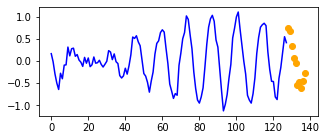

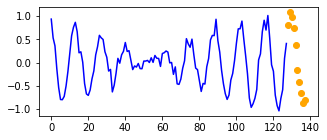

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [476]:
np.random.seed(1) # Fixing the seed, so that data is always the same
seq_length = 128  # Sequence length used for training
look_ahead =  10  # The number of data points the model should predict 


def gen_data(size=1000, noise=0.1, look_ahead = 10): # We create 1000 data-points
  s = seq_length + look_ahead
  d = np.zeros((size, s,1))
  for i in range(size):
    start = np.random.uniform(0, 2*np.pi) # Random start point
    d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
  return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
for i in range(2):
  plt.figure(num=None, figsize=(5,2))  
  plt.plot(range(0, seq_length),X[i,:,0],'b-')
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')

plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')

In [477]:
def plot_cnn(X, Y):
    for i in range(2):
      plt.figure(num=None, figsize=(5,2))  
      plt.plot(range(0, seq_length),X[i,:,0],'b-')
      plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:, 0],'bo',color='orange')


## A) 1D Convolution without dilation rate


### Build network
Here we define a Neural network with 1D convolutions and "causal" padding. 

Build a first model using the causal convolutions. Don't specify the sequence length (batch_input_shape=(None, None, 1)), so you can use a different sequence length in prediction later. The network should have 4, 1-dimensional convolutional layers, with a kernelsize of `ks=5` and 32 features. Use the keras function `Convolution1D` for that. The network should report 10 values that the end. You can achive this with the function.

```{pyhon}
def slice(x, slice_length):
    return x[:,-slice_length:,:]
...
model1.add(Lambda(slice, arguments={'slice_length':look_ahead}))
```

Which you add at the end of the network.

In [478]:
def slice(x, slice_length):
    return x[:, -slice_length:, :]

def network(dilr = 1):
    model = Sequential()

    # Input layer
    model.add(Conv1D(32, kernel_size = 5, dilation_rate = dilr, input_shape = (None, 1), padding = "causal"))
    model.add(Conv1D(32, kernel_size = 5, dilation_rate = dilr, padding = "causal", activation = "relu"))
    model.add(Conv1D(32, kernel_size = 5, dilation_rate = dilr, padding = "causal", activation = "relu"))
    model.add(Conv1D(32, kernel_size = 5, dilation_rate = dilr, padding = "causal", activation = "relu"))

    # Output layer
    model.add(Dense(1))
    model.add(Lambda(slice, arguments = {'slice_length': look_ahead}))

    model.summary()
    return model

In [479]:
model1 = network()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_69 (Conv1D)           (None, None, 32)          192       
_________________________________________________________________
conv1d_70 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_71 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_72 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
dense_28 (Dense)             (None, None, 1)           33        
_________________________________________________________________
lambda_19 (Lambda)           (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
_________________________________________________

- first 800 sequences for training 
- last 200 for validation
- mean squared error (MSE) (should get a MSE of approx 0.02 to 0.03)

In [480]:
X, Y = gen_data()
# Training data
x_train = X[:800]
y_train = Y[:800]

# Validation data
x_valid = X[800:]
y_valid = Y[800:]

In [481]:
x_train.shape

(800, 128, 1)

In [482]:
model1.compile(optimizer = "sgd", loss = "mse")
model1.fit(x_train, y_train, epochs = 25, batch_size = 10)

Epoch 1/25
800/800 [==============================] - 2s 3ms/step - loss: 0.1866
Epoch 2/25
800/800 [==============================] - 1s 1ms/step - loss: 0.0526
Epoch 3/25
800/800 [==============================] - 1s 1ms/step - loss: 0.0380
Epoch 4/25
800/800 [==============================] - 1s 1ms/step - loss: 0.0349
Epoch 5/25
800/800 [==============================] - 1s 1ms/step - loss: 0.0334
Epoch 6/25
800/800 [==============================] - 1s 1ms/step - loss: 0.0323
Epoch 7/25
800/800 [==============================] - 1s 1ms/step - loss: 0.0314
Epoch 8/25
800/800 [==============================] - 1s 1ms/step - loss: 0.0307
Epoch 9/25
800/800 [==============================] - 2s 2ms/step - loss: 0.0300
Epoch 10/25
800/800 [==============================] - 2s 2ms/step - loss: 0.0295
Epoch 11/25
800/800 [==============================] - 2s 3ms/step - loss: 0.0290
Epoch 12/25
800/800 [==============================] - 2s 3ms/step - loss: 0.0285
Epoch 13/25
800/800 [====

### Make repeated predictions

Since we work with simulated data, we can produce as much new data as we like. We can also switch off the noise and check how well the model can extract the real underlying pattern in the data.

In [483]:
x_test,y_test = gen_data(size=1,noise=0.0)
print(x_test.shape)
print(y_test.shape)
model1.predict(x_test).reshape(-1) #Predicts 10 value

(1, 128, 1)
(1, 10, 1)


array([ 5.1695859e-01,  3.0601195e-01,  7.4839622e-02, -1.1542949e-01,
       -2.7991930e-01, -3.3393303e-01, -2.9696631e-01, -2.1252614e-01,
       -1.2774470e-01,  3.3068657e-04], dtype=float32)

Write a function which predicts 10 values from a starting sequence of size 128. Then add these predicted values to the starting sequence and uses this sequence of length 138 as a new starting sequence. Repeat this procedure 12 times. You should get a prediction for 120 time points in the future. 

In [484]:
def extend(data, sample = 1, model = model1):
    """
        Sample new values from the trained model and stack them on already existing data.
        
        @param data - the data to use for the prediction
        @param sample - how many times to sample from the data
        @model - the model to use for the prediction
        
        @return tuple in format (list of samples, update_data)
    """
    
    if sample <= 0:
        raise ArgumentError("Can't take less than 1-Sample from the data.")
        
    if len(data.shape) != 3 and data.shape[0] != 1 and data.shape[2] != 1:
        raise ArgumentError("")
    
    predictions = []
    for i in range(sample):
        sample = model.predict(data).reshape(1, 10, 1)
        data = np.hstack([data, sample])
        predictions.append(sample.reshape(-1));
    
    
    return (predictions, data)

In [485]:
def plot_sequence(data, samples, reshape = True):
    
    """
        Plots the sequence as a scatter-plot.
    """
    
    fig = plt.figure(figsize = (8, 8))
    sns.lineplot(x = list(range(data.shape[1])), y = data.reshape(data.shape[1]))
    
    x = list(range(len(samples) * 10))
    stacked_samples = np.hstack(samples)
    sns.scatterplot(x = x, y = stacked_samples)

In [486]:
def plot_cnn(X, Y):
    
    sample_size = X.shape[0]
    
    for i in range(sample_size):
      plt.figure(num=None, figsize=(5,2))  
      plt.plot(range(0, seq_length),X[i,:, 0],'b-')
      plt.plot(range(seq_length, seq_length + look_ahead),Y[i][:],'b-',color='orange')

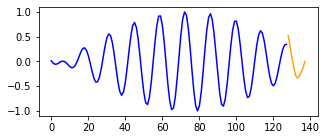

In [487]:
(samples, updated_data) = extend(x_test)
plot_cnn(x_test, samples)

## B) 1D Convolution with dilation rate

Here we define a Neural network with 1D convolutions and "causal" padding, this time with dilation rate, so we are able to look back longer in time (see figure below)
 
![](https://i.stack.imgur.com/20xRe.png)
Build the same network as in A) but this time with dilation_rates 1,2,4,8 

In [488]:
OPTIM = "sgd"
LOSS = "mse"
EPOCHS = 10
MBS = 10

In [489]:
model_r1 = network()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_73 (Conv1D)           (None, None, 32)          192       
_________________________________________________________________
conv1d_74 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_75 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_76 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
dense_29 (Dense)             (None, None, 1)           33        
_________________________________________________________________
lambda_20 (Lambda)           (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
_________________________________________________

In [490]:
model_r1.compile(optimizer = OPTIM, loss = LOSS)
model_r1.fit(x_train, y_train, epochs = EPOCHS, batch_size = MBS)

Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.1622
Epoch 2/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0529
Epoch 3/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0419
Epoch 4/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0384
Epoch 5/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0365
Epoch 6/10
800/800 [==============================] - 2s 3ms/step - loss: 0.0350
Epoch 7/10
800/800 [==============================] - 2s 3ms/step - loss: 0.0339
Epoch 8/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0329
Epoch 9/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0321
Epoch 10/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0314


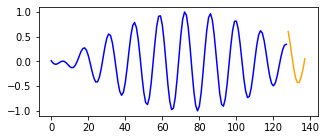

In [491]:
(samples, updated_data) = extend(x_test, TIMES_UPDATE_ITSELF, model = model_r1)
plot_cnn(x_test, samples)

In [492]:
model_r2 = network(2)

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_77 (Conv1D)           (None, None, 32)          192       
_________________________________________________________________
conv1d_78 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_79 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_80 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
dense_30 (Dense)             (None, None, 1)           33        
_________________________________________________________________
lambda_21 (Lambda)           (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
_________________________________________________

In [493]:
model_r2.compile(optimizer = OPTIM, loss = LOSS, metrics = ["acc"])
model_r2.fit(x_train, y_train, epochs = EPOCHS, batch_size = MBS)

Epoch 1/10
800/800 [==============================] - 6s 8ms/step - loss: 0.1411 - acc: 0.0000e+00
Epoch 2/10
800/800 [==============================] - 2s 3ms/step - loss: 0.0639 - acc: 0.0000e+00
Epoch 3/10
800/800 [==============================] - 2s 3ms/step - loss: 0.0584 - acc: 0.0000e+00
Epoch 4/10
800/800 [==============================] - 2s 3ms/step - loss: 0.0547 - acc: 0.0000e+00
Epoch 5/10
800/800 [==============================] - 2s 3ms/step - loss: 0.0515 - acc: 0.0000e+00
Epoch 6/10
800/800 [==============================] - 3s 4ms/step - loss: 0.0486 - acc: 0.0000e+00
Epoch 7/10
800/800 [==============================] - 2s 3ms/step - loss: 0.0458 - acc: 0.0000e+00
Epoch 8/10
800/800 [==============================] - 1s 1ms/step - loss: 0.0432 - acc: 0.0000e+00
Epoch 9/10
800/800 [==============================] - 1s 2ms/step - loss: 0.0405 - acc: 0.0000e+00
Epoch 10/10
800/800 [==============================] - 1s 2ms/step - loss: 0.0381 - acc: 0.0000e+00


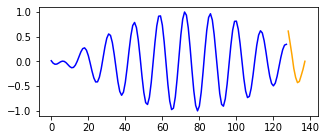

In [494]:
(samples, updated_data) = extend(x_test, TIMES_UPDATE_ITSELF, model = model_r2)
plot_cnn(x_test, samples)

In [495]:
model_r4 = network(4)

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_81 (Conv1D)           (None, None, 32)          192       
_________________________________________________________________
conv1d_82 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_83 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_84 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
dense_31 (Dense)             (None, None, 1)           33        
_________________________________________________________________
lambda_22 (Lambda)           (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
_________________________________________________

In [496]:
model_r4.compile(optimizer = OPTIM, loss = LOSS, metrics = ["acc"])
model_r4.fit(x_train, y_train, epochs = EPOCHS, batch_size = MBS)

Epoch 1/10
800/800 [==============================] - 4s 6ms/step - loss: 0.2067 - acc: 0.0000e+00
Epoch 2/10
800/800 [==============================] - 2s 2ms/step - loss: 0.1020 - acc: 0.0000e+00
Epoch 3/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0620 - acc: 0.0000e+00
Epoch 4/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0390 - acc: 0.0000e+00
Epoch 5/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0276 - acc: 0.0000e+00
Epoch 6/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0231 - acc: 0.0000e+00
Epoch 7/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0214 - acc: 0.0000e+00
Epoch 8/10
800/800 [==============================] - 2s 2ms/step - loss: 0.0204 - acc: 0.0000e+00
Epoch 9/10
800/800 [==============================] - 2s 3ms/step - loss: 0.0198 - acc: 0.0000e+00
Epoch 10/10
800/800 [==============================] - 1s 1ms/step - loss: 0.0193 - acc: 0.0000e+00


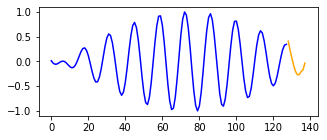

In [497]:
(samples, updated_data) = extend(x_test, TIMES_UPDATE_ITSELF, model = model_r4)
plot_cnn(x_test, samples)

In [498]:
model_r8 = network(8)

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_85 (Conv1D)           (None, None, 32)          192       
_________________________________________________________________
conv1d_86 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_87 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
conv1d_88 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
dense_32 (Dense)             (None, None, 1)           33        
_________________________________________________________________
lambda_23 (Lambda)           (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
_________________________________________________

In [499]:
model_r8.compile(optimizer = OPTIM, loss = LOSS, metrics = ["acc"])
model_r8.fit(x_train, y_train, epochs = EPOCHS, batch_size = MBS)

Epoch 1/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2214 - acc: 0.0000e+00
Epoch 2/10
800/800 [==============================] - 1s 2ms/step - loss: 0.0813 - acc: 0.0000e+00
Epoch 3/10
800/800 [==============================] - 1s 1ms/step - loss: 0.0199 - acc: 0.0000e+00
Epoch 4/10
800/800 [==============================] - 1s 1ms/step - loss: 0.0160 - acc: 0.0000e+00
Epoch 5/10
800/800 [==============================] - 1s 1ms/step - loss: 0.0154 - acc: 0.0000e+00
Epoch 6/10
800/800 [==============================] - 1s 1ms/step - loss: 0.0150 - acc: 0.0000e+00
Epoch 7/10
800/800 [==============================] - 1s 1ms/step - loss: 0.0148 - acc: 0.0000e+00
Epoch 8/10
800/800 [==============================] - 1s 1ms/step - loss: 0.0146 - acc: 0.0000e+00
Epoch 9/10
800/800 [==============================] - 1s 2ms/step - loss: 0.0144 - acc: 0.0000e+00
Epoch 10/10
800/800 [==============================] - 1s 2ms/step - loss: 0.0143 - acc: 0.0000e+00


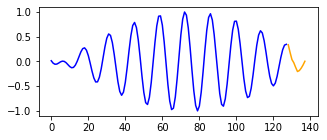

In [500]:
(samples, updated_data) = extend(x_test, TIMES_UPDATE_ITSELF, model = model_r8)
plot_cnn(x_test, samples)

## C) Simple RNN

Now, use a RNN cell Keras `SimpleRNN` to see if we are able to learn the data generating process. Start with a hidden state size of 12. Repeat the task from A) and B). Consider to add several layers of cells and play with the state size.

### Make repeated predictions
As in A) make preaded preditions on noise less data.

In [501]:
LOOK_AHEAD_RN = 12

X,Y = gen_data(look_ahead = LOOK_AHEAD_RN)
x_train, y_train = X[:800], Y[:800]
x_test, y_test = X[800:], Y[800:]

In [502]:
model_rn = Sequential()
model_rn.add(SimpleRNN(LOOK_AHEAD_RN, input_shape = (1, 128), return_sequences = True)) # input_shape = (sequence_length, input_dim)
model_rn.summary()

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_34 (SimpleRNN)    (None, 1, 12)             1692      
Total params: 1,692
Trainable params: 1,692
Non-trainable params: 0
_________________________________________________________________


In [503]:
model_rn.compile(optimizer = "sgd", loss = "mse")
model_rn.fit(x_train.reshape(800, 1, 128), y_train.reshape(800, 1, LOOK_AHEAD_RN), epochs = 20, batch_size = MBS)

Epoch 1/20
800/800 [==============================] - 6s 8ms/step - loss: 0.2812
Epoch 2/20
800/800 [==============================] - 1s 906us/step - loss: 0.0706
Epoch 3/20
800/800 [==============================] - 1s 928us/step - loss: 0.0356
Epoch 4/20
800/800 [==============================] - 1s 941us/step - loss: 0.0272
Epoch 5/20
800/800 [==============================] - 1s 919us/step - loss: 0.0246
Epoch 6/20
800/800 [==============================] - 1s 919us/step - loss: 0.0237
Epoch 7/20
800/800 [==============================] - 1s 925us/step - loss: 0.0233
Epoch 8/20
800/800 [==============================] - 1s 936us/step - loss: 0.0231
Epoch 9/20
800/800 [==============================] - 1s 905us/step - loss: 0.0230
Epoch 10/20
800/800 [==============================] - 1s 961us/step - loss: 0.0229
Epoch 11/20
800/800 [==============================] - 1s 893us/step - loss: 0.0228
Epoch 12/20
800/800 [==============================] - 1s 886us/step - loss: 0.0228
Epo

In [504]:
predicted = model_rn.predict(x_test.reshape(200, 1, 128))
predicted.shape

(200, 1, 12)

In [505]:
def sample_rnn(initial_data, sample_times = 10, model = model_rn):
    
    """
        Sample n-times from the given model.
    """
    
    reverse_dimensions = lambda data: data.reshape([data.shape[0]] + list(reversed(list(data.shape[1:]))))
    
    sampled = []
    data = reverse_dimensions(initial_data)
    
    # Get new
    for i in range(sample_times):
        new_sample = model.predict(data)
        
        data = np.hstack([reverse_dimensions(data), reverse_dimensions(new_sample)])
        data = reverse_dimensions(data)[:, :, LOOK_AHEAD_RN:]
        
        # Add to total new samples
        ns_shape = new_sample.shape
        sampled.append(new_sample.reshape(ns_shape[0], ns_shape[-1]))
        
    return np.hstack(sampled)

In [506]:
def plot_rnn_data(X, Y):
    
    x_shape = X.shape
    y_shape = Y.shape
    
    for i in range(2):
      plt.figure(num=None, figsize=(5,2))  
      plt.plot(range(0, x_shape[1]),X[i,:,0],'b-')
      plt.plot(range(x_shape[1], x_shape[1] + y_shape[-1]),Y[i,:],'b-',color='orange')

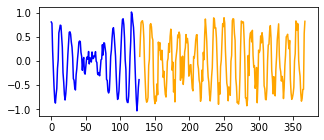

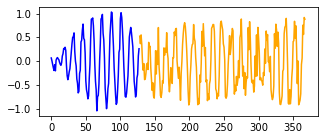

In [507]:
samples = sample_rnn(x_test, sample_times = 20)
plot_rnn_data(x_test, samples)

## D) LSTM Cell
Repeat C) but now with an LSTM cell.

In [508]:
model_ls = Sequential()
model_ls.add(LSTM(12, input_shape=(1, 128), return_sequences = True))

model_ls.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 12)             6768      
Total params: 6,768
Trainable params: 6,768
Non-trainable params: 0
_________________________________________________________________


In [509]:
model_ls.compile(optimizer = "sgd", loss = "mse")
model_ls.fit(x_train.reshape(800, 1, 128), y_train.reshape(800, 1, LOOK_AHEAD_RN), epochs = EPOCHS, batch_size = MBS)

Epoch 1/10
800/800 [==============================] - 4s 5ms/step - loss: 0.2586
Epoch 2/10
800/800 [==============================] - 0s 519us/step - loss: 0.2200
Epoch 3/10
800/800 [==============================] - 0s 537us/step - loss: 0.1978
Epoch 4/10
800/800 [==============================] - 0s 515us/step - loss: 0.1823
Epoch 5/10
800/800 [==============================] - 0s 518us/step - loss: 0.1699
Epoch 6/10
800/800 [==============================] - 0s 505us/step - loss: 0.1594
Epoch 7/10
800/800 [==============================] - 0s 598us/step - loss: 0.1500
Epoch 8/10
800/800 [==============================] - 1s 673us/step - loss: 0.1416
Epoch 9/10
800/800 [==============================] - 0s 622us/step - loss: 0.1339
Epoch 10/10
800/800 [==============================] - 0s 486us/step - loss: 0.1268


In [510]:
samples = sample_rnn(x_test, sample_times = 20, model = model_ls)

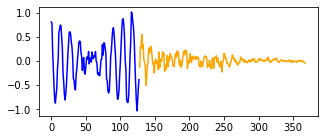

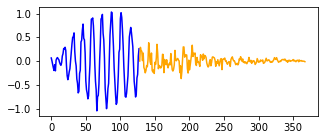

In [511]:
plot_rnn_data(x_test, samples)